## Company Background
EMO is a manufacturer of motorcycles. The company successfully launched its first electric moped in India in 2019. The product team knows how valuable owner reviews are in making improvements to their mopeds. 

Unfortunately they often get reviews from people who never owned the moped. They don’t want to consider this feedback, so would like to find a way to identify reviews from these people. They have obtained data from other mopeds, where they know if the reviewer owned the moped or not. They think this is equivalent to their own reviews.   

Can we predict which reviews come from people who have never owned the moped before?  


## Dataset
The dataset contains reviews about other mopeds from a local website. The data you will use for this analysis can be accessed here: `"data/moped.csv"`

| Column Name      | Criteria                                                                                                                                                                    |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Used it for      | Character, the purpose of the electric moped for the user, one of “Commuting”, “Leisure”.                                                                                   |
| Owned for        | Character, duration of ownership of vehicle one of  “<= 6 months”, “> 6 months”, “Never Owned”.  Rows that indicate ownership should be combined into the category “Owned”. |
| Model name       | Character, the name of the electric moped.                                                                                                                                   |
| Visual Appeal    | Numeric, visual appeal rating (on a 5 point scale, replace missing values with 0).                                                                                           |
| Reliability      | Numeric, reliability rating (on a 5 point scale, replace missing values with 0).                                                                                             |
| Extra Feature    | Numeric, extra feature rating (on a 5 point scale, replace missing values with 0).                                                                                         |
| Comfort          | Numeric, comfort rating (on a 5 point scale, replace missing values with 0).                                                                                                 |
| Maintenance cost | Numeric, maintenance cost rating (on a 5 point scale, replace missing values with 0).                                                                                        |
| Value for money  | Numeric, value for money rating (on a 5 point scale, replace missing values with 0).                                                                                         |

## Data Validation
For the columns containing ratings, we have to make sure that all the ratings are valid. To do this, we first replaced all missing ones with **0** (we assume that a missing note is a null note), then we checked that the range of note values is between **0 and 5** (inclusive).

As for the other columns `Used it for` and `Owned for` we transformed them into a categorical type. It should also be noted that for the `Owned for` column we have reduced the set of possible values to `{"Owned" , "Never Owned"}`. This last modification will allow us to easily perform our classification task later on.

In [1]:
import pandas as pd

moped: pd.DataFrame = pd.read_csv("data/moped.csv")

# Definition of validity sets
rating_validity_set: set = set(range(6))
used_it_for_set: set = {"Commuting", "Leisure"}
owned_for_set: set = {"<= 6 months", "> 6 months", "Never owned"}
owned_for_after_combined: set = {"Owned", "Never owned"}
rating_field: set = {'Visual Appeal', 'Reliability', 'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money'}

# Replacement of missing values for notations and verification of the validity of the values
assert not set(moped["Used it for"]) - used_it_for_set
moped["Used it for"] = moped["Used it for"].astype("category")

moped = moped.fillna(value={field:0 for field in rating_field})
assert any(not (set(moped[field]) - rating_validity_set) for field in rating_field)



assert not set(moped["Owned for"]) - owned_for_set
moped = moped.replace({"<= 6 months": "Owned", "> 6 months": "Owned"})
assert not set(moped["Owned for"]) - owned_for_after_combined
moped["Owned for"] = moped["Owned for"].astype("category")

moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Used it for       713 non-null    category
 1   Owned for         713 non-null    category
 2   Model Name        713 non-null    object  
 3   Visual Appeal     713 non-null    float64 
 4   Reliability       713 non-null    float64 
 5   Extra Features    713 non-null    float64 
 6   Comfort           713 non-null    float64 
 7   Maintenance cost  713 non-null    float64 
 8   Value for Money   713 non-null    float64 
dtypes: category(2), float64(6), object(1)
memory usage: 40.8+ KB


## Exploratory Analysis

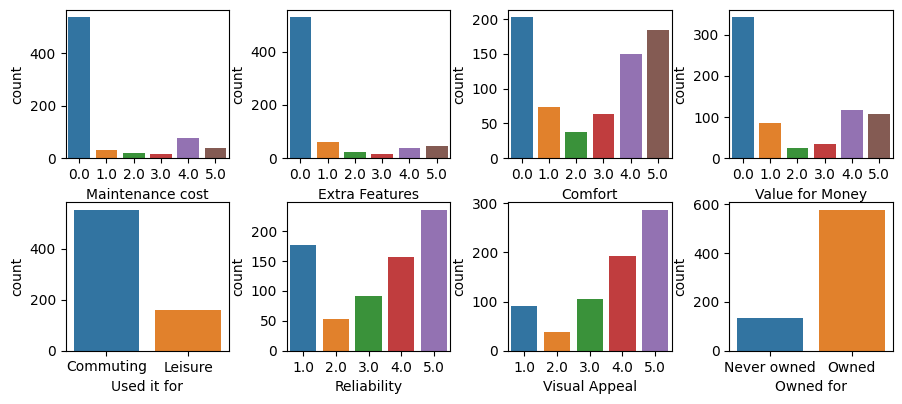

In [2]:
# Exploratory Analysis
# Explore the characteristics of the variables in the data

# Start coding here... 
import seaborn as sns
import matplotlib.pyplot as plt

# Display of variable distributions
fig, ax = plt.subplots(2, 4, figsize=(9, 4))
fig.tight_layout()
for i, variable in enumerate(set(moped.columns) - {"Model Name"}):
	sns.countplot(x=variable, data=moped, ax=ax[i//4, i%4])
plt.show()


In the analysis of the distributions of the variables, we can initially notice that the majority of the users do not leave notes (**note of 0**). In the following analysis we will see if this absence of note is due to the possession of motorcycles or not.

Moreover we can notice that motorcycles are generally used for commuting so we will also see if this is impacted or not by motorcycle ownership.

### Impact of motorcycle possession on the presence of ratings

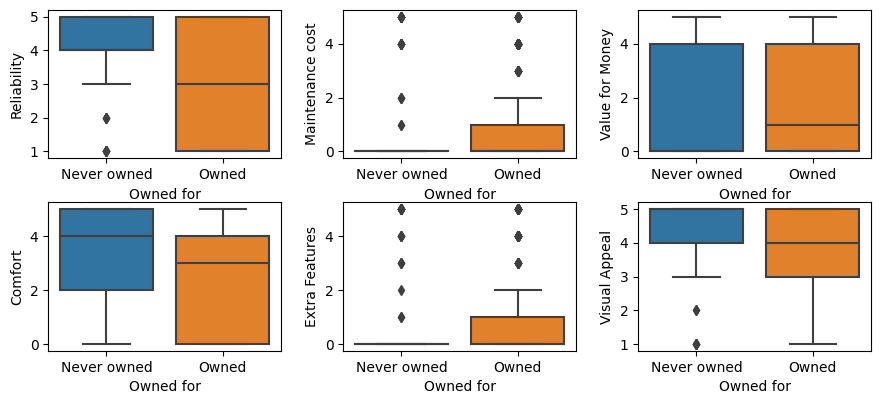

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(9, 4))
fig.tight_layout()
for i, variable in enumerate(rating_field):
	g = sns.boxplot(x='Owned for', y=variable,data=moped, ax=ax[i//3, i%3])
plt.show()

The distribution of ratings seems to be quite similar for both groups. However, we can notice that the distribution of the non owners of motorcycles is more condensed towards high scores. Nevertheless, in categories such as cost of maintenance, value for money and extra features it can be noticed that this time the non-owners have a distribution condensed towards the bottom.

### Impact of motorcycle possession on the type of using

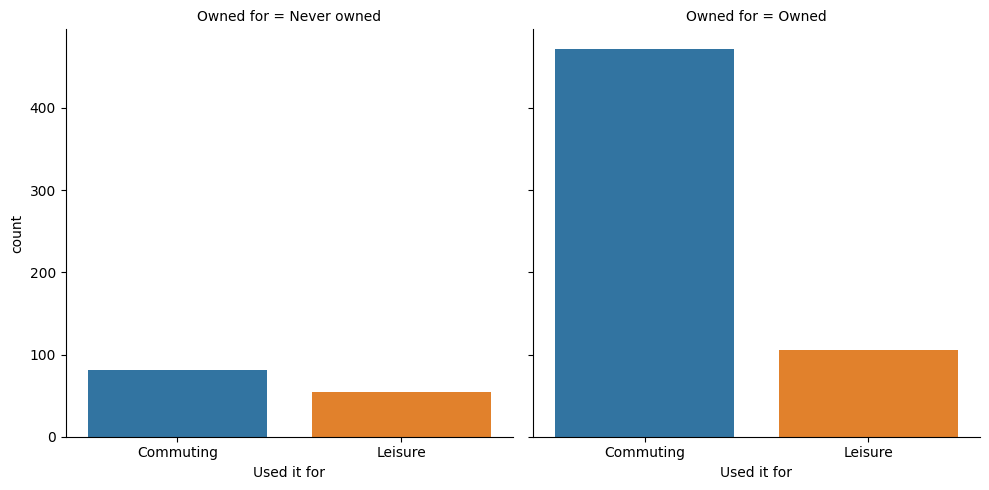

In [4]:
fig.tight_layout()
sns.catplot(x='Used it for',data=moped, col='Owned for', kind="count")
plt.show()

## Model Fitting
Describe what you found in the exploratory analysis. In your description you should:
- Reference at least two different data visualizations you created above to demonstrate the characteristics of variables
- Reference at least one data visualization you created above to demonstrate the relationship between two or more variables
- Describe what your exploratory analysis has told you about the data
- Describe any changes you have made to the data to enable modeling


The detection of possession or non-possession of motorcycles corresponds to a binary classification problem. We will train two models (KNN and DecisionTree) and observe their performance


### Preparation of training & test data

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

moped_dummies = pd.get_dummies(moped, columns=["Model Name", "Used it for"])
X, y = moped_dummies.drop("Owned for", axis=1).values, moped_dummies['Owned for'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
            random_state=10, stratify=y)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (499, 46)
y_train shape: (499,)
X_test shape: (214, 46)
y_test shape: (214,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier 

logreg = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier(max_depth=2, random_state=1)
models = {"Logistic regression": logreg, "Decision Tree Classifier": decision_tree}
model_score = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    model_score[model_name] = model.score(X_test, y_test)
    
for model_name, model_score in model_score.items():
    print(f"Score of {model_name} : {model_score}")

Score of Logistic regression : 0.8411214953271028
Score of Decision Tree Classifier : 0.8084112149532711


In [9]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba9ce6d7-9cfe-4b88-82bf-16bbd155a771' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>